<span style="font-family:Papyrus; font-size:3em;">Computational Experiments</span>

<span style="font-family:Papyrus; font-size:2em;">One Factor at a Time (OFT)</span>

# Overview

# Preliminaries

In [42]:
import tellurium as te
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
import seaborn as sns
import pandas as pd

In [2]:
# Constants
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value

This lecture discusses how to use tellurium simulations to answer science questions.
1. Workflow
   - Articulate the questions to address
   - Select the model
   - Identify parameters and species to manipulate and how they will be modified
     - Changes in initial values
     - Changes in values during simulation
   - Select measures to report
   - Visualize the results
   - Construct codes that encapsulate each step
   - Model debugging
1. Learning objectives
   - Creating functions for reuse
   - Functions in a python module
   - Test codes for reusable functions

# Wolf Model

What is the final plot?
- x axis: percent change
- y axis: parameter name
- values: color code amount changed

How organize the qualitive values?

## Constants for Model

In [3]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""

In [4]:
WOLF_RR = te.loada(WOLF_MODEL)
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_DATA = WOLF_RR.simulate(START, END, NUMPT)
WOLF_PRMS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]

## Exploration of the Model

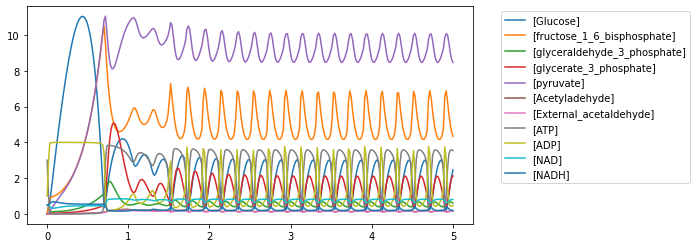

In [5]:
def timePlots(data=WOLF_DATA, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 4))
    p = ax.plot(data[:,0], data[:,1:])
    _ = ax.legend(p, data.colnames[1:], bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
timePlots()

## Research Question

**Question**: What is the effect of percent changes in each parameter on the amplitude and freuency of glycolytic oscillations?

# Running Simulations With Changes in Parameter Values

In [6]:
parameter = "J1_k1"
changeFracs = [-1, 0, 1]
roadrunner = WOLF_RR

def runSimulations(parameter, percents, isPlot=True):
    """
    Runs experiments and produces plots for the fractional changes in parameter values.

    Parameters
    ----------
    parameter: str
    percents: list-float
        list of percent change in values
          (smallest value is -100)
          
    Returns
    -------
    dict: key=pct, value=data
    """
    roadrunner = te.loada(WOLF_MODEL)
    baseValue = roadrunner[parameter]
    if not parameter in roadrunner.keys():
        raise ValueError("Unknown parameter name: %s" % parameter)
    resultDct = {}
    for percent in percents:
        roadrunner.resetAll()
        percent = max(percent, SMALLEST_PCT)
        frac = 0.01*percent
        newValue = baseValue*(1 + frac)
        roadrunner[parameter] = newValue
        data = roadrunner.simulate(START, END, NUMPT)
        title = "%s: %f (%d%%)" % (parameter, newValue, percent)
        resultDct[percent] = data
        if isPlot:
            timePlots(data=data, title=title)
    return resultDct

# Tests
percents = [-10, 0, 10]
resultDct = runSimulations("J1_Ki", percents, isPlot=False)
assert(len(set(percents).symmetric_difference(resultDct.keys())) == 0)

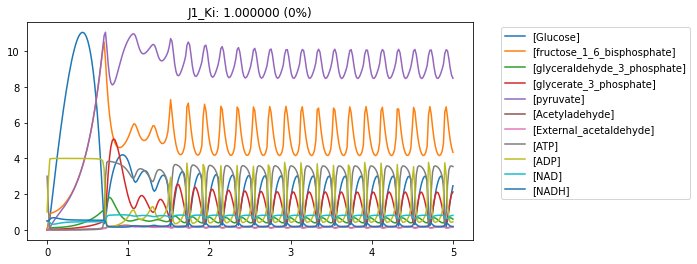

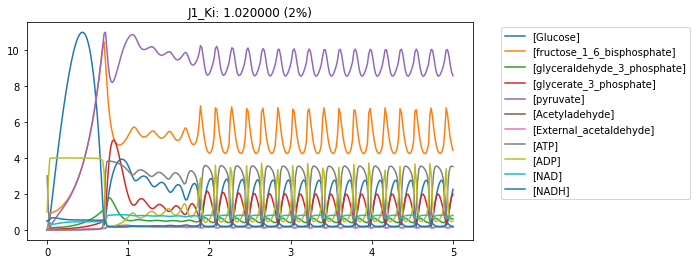

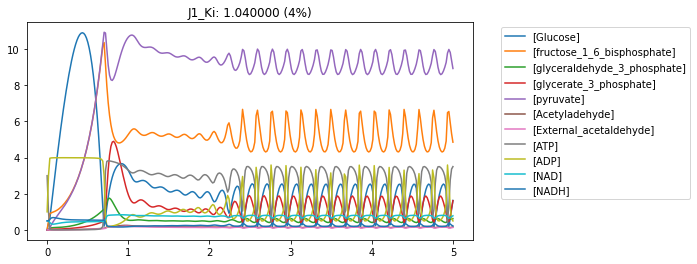

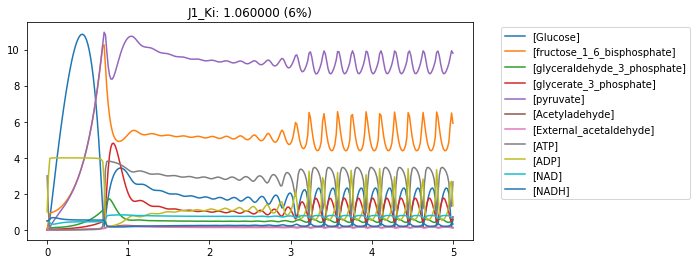

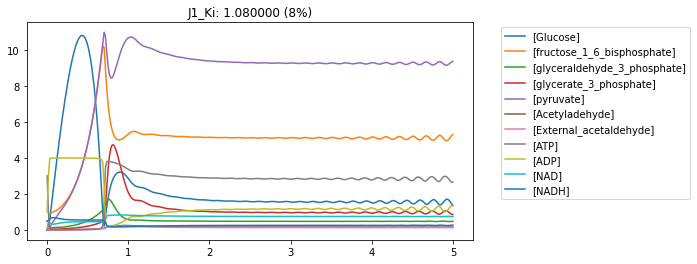

In [7]:
# Experiments 
changes = 2*np.array(range(5))
length = len(changes)
#changes = changes - float((length - 1)/2)
_ = runSimulations("J1_Ki", changes)

**Observations**
1. J1_Ki: Frequency increases to a straight line. In dynamical systems, this is a bifurcation from a "center" to a stable node.
1. Even for 1 parameter, this is painful to evaluate. Then, we need to transcribe the frequency numbers. Need to report summary of key result, not do a full plot. Also, want to have finer granularity about when the perodicities are extinguished.

# Calculating Responses

The response values for our experiments are FFT frequencies and amplitudes.
This section develops codes that calculate responses.

Our steps are:
1. Construct FFT for data. Function:
   - input: molecule, data, data ofset
   - output: list-freqs, list-fftAmplitudes
2. Plot FFTs. Should plot so make sure that the data make sense.
3. Calculate response for an experiment by molecule

In [8]:
def calculateFft(molecule, data, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    offset: int
        Initial data that are not included in the FFT calculation
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("Glucose", WOLF_DATA)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude

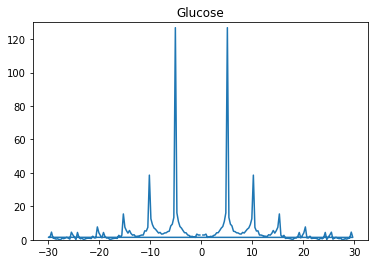

In [9]:
def plotFft(molecule, data=WOLF_DATA, ax=None, **kwargs):
    """
    Plot the FFT for a molecule.
    
    Parameters
    ----------
    data: NamedArray
    ax: Matplotlib.Axes
    kwargs: dict
        optional arguments passed to FFT calculation
    """
    if ax is None:
        _, ax = plt.subplots(1,1)
    freqs, fftValues = calculateFft(molecule, data=data, **kwargs)
    ax.plot(freqs, fftValues)
    ax.set_title(molecule)
    ax.set_ylim([0, 130])
    
# Tests
plotFft("Glucose")  # "Smoke" test

In [10]:
def getFrequencyAmplitude(molecule, data):
    """
    Obtains the highest amplitude frequency and value for the molecule.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    
    Returns
    -------
    frequency: float
    amplitude: float
    """
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    frequencies, amplitudes = calculateFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(freqs)), key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return frequencies[topIdx], amplitudes[topIdx]

# Tests
frequency, amplitude = getFrequencyAmplitude("Glucose", WOLF_DATA)
assert(frequency > 5.0)
assert(amplitude > 90)

# Running a Study

A study is a collection of experiments in which one or more factors is set to different levels.

In [11]:
def runSimulation(parameterDct, roadrunner=None):
    """
    Runs experiments and produces plots for the fractional changes in parameter values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float
           percent change
       
    Returns
    -------
    namedArray: results of simulation
    """
    if roadrunner is None:
        roadrunner = te.loada(WOLF_MODEL)
    else:
        roadrunner.resetAll()
    for parameter, percent in parameterDct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate(START, END, NUMPT)
    return data

#Test
assert(len(runSimulation({"J1_Ki": 0.2})) > 0)

In [12]:
def runExperiment(parameterDct):
    """
    Runs an experiment by chaning parameters by the specified fractions.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: percent change the parameter
       
    Returns
    -------
    frequencyDct: dict
        key: molecule
        value: frequency with largest amplitude
    amplitudeDct: dict
        key: molecule
        value: largest amplitude
    """
    data = runSimulation(parameterDct)
    frequencyDct = {}
    amplitudeDct = {}
    molecules = [s[1:-1] for s in data.colnames if s != TIME]
    for molecule in molecules:
        frequency, amplitude = getFrequencyAmplitude(molecule, data)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return frequencyDct, amplitudeDct

# Test
frequencyDct, amplitudeDct = runExperiment({"J1_Ki": 0.03})
assert(len(frequencyDct) == len(amplitudeDct))

In [65]:
# TODO: Return a dataframe
def runExperimentLevels(parameter, percents):
    """
    Runs experiments for one parameter of the model at different percent changes in the parameter value (levels).
    
    Parameter
    ---------
    parameter: str
    percents: list-float
        percent change in parameter
        
    Returns
    -------
    frequencyDF: DataFrame
        index: percent
        columns: molecule
        values: percent change in frequency w.r.t. baseline
    amplitudeDF: DataFrame
        index: percent
        columns: molecule
        values: percent change in amplitude w.r.t. baseline
    """
    # Calculate the baseline values
    baseFrequencyDct, baseAmplitudeDct = runExperiment({})
    #
    def calc(dct, isFrequency=True):
        if isFrequency:
            baseDct = baseFrequencyDct
        else:
            baseDct = baseAmplitudeDct
        result = {m: 100*(dct[m] - baseDct[m])/baseDct[m] for m in baseDct.keys()}
        return result
    #
    # Iterate across changes
    frequencyDct = {m: [] for m in baseFrequencyDct.keys()}
    amplitudeDct = {m: [] for m in baseAmplitudeDct.keys()}
    for percent in percents:
        parameterDct = {parameter: percent}
        fDct, aDct = runExperiment(parameterDct)
        fPct = calc(fDct, isFrequency=True)
        aPct = calc(aDct, isFrequency=False)
        [frequencyDct[m].append(fPct[m]) for m in baseFrequencyDct.keys()]
        [amplitudeDct[m].append(aPct[m]) for m in baseAmplitudeDct.keys()]
    amplitudeDF = pd.DataFrame(amplitudeDct)
    amplitudeDF.index = percents
    frequencyDF = pd.DataFrame(frequencyDct)
    frequencyDF.index = percents
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, 0, 7]
fDF, aDF = runExperimentLevels("J1_Ki", percents)
assert(np.isclose(fDF.loc[percents[0], "Glucose"], -1*fDF.loc[percents[-1], "Glucose"]) )
assert(aDF.loc[percents[-1], "Glucose"] < 0 )
assert(aDF.loc[percents[0], "Glucose"] > 0 )

In [66]:
def runStudy(percents=[-100, -50, -10, 0, 5, 10, 20]):
    """
    Collects responses for changes in all parameters
    
    Parameters
    ----------
    percents: list-float
    
    Returns
    -------
    dict
        key: parameter
        value: frequencyDF, amplitudeDF
    """
    resultDct = {}
    for parameter in WOLF_PRMS:
        resultDct[parameter] = runExperimentLevels(parameter, percents)
    return resultDct

# Tests
assert(len(runStudy()) > 0)

In [67]:
resultDct = runStudy()

# Visualizing the Results of a Study

Construct line plots of dR/R vs. dP/P, where R is the response and P is the parameter value.
Want to construct a heatmap with:
- rows: parameters
- columns: percent change in parameter value
- color: percent change in value (frequency, amplitude) w.r.t. a change of 0

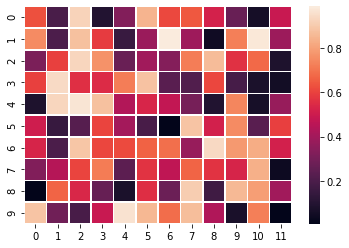

In [16]:
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, linewidth=0.5)
plt.show()

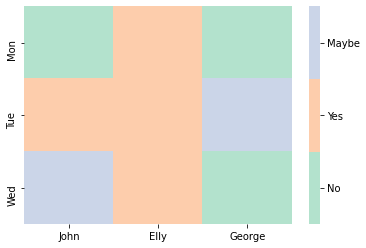

In [17]:
import pandas as pd
df = pd.DataFrame({"John":"No Yes Maybe".split(),
                   "Elly":"Yes Yes Yes".split(),
                   "George":"No Maybe No".split()},
                   index="Mon Tue Wed".split())


value_to_int = {j:i for i,j in enumerate(pd.unique(df.values.ravel()))} # like you did
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 
ax = sns.heatmap(df.replace(value_to_int), cmap=cmap) 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))                                          
plt.show()

Need to create a data structure with colnames that are parameters, rows are pct change, and values that are changes.

``resultDct`` is organized as:
- key: parameter name
- key: dict
  - key: percent change
  - value: frequencyDct, amplitudeDct
    - molecule
    - value

In [19]:
resultDct.keys()

dict_keys(['J0_inputFlux', 'J1_k1', 'J1_Ki', 'J1_n', 'J2_k', 'J3_k', 'J4_kg', 'J4_kp', 'J4_ka', 'J4_kk', 'J5_k', 'J6_k', 'J7_k', 'J8_k1', 'J8_k2', 'J9_k', 'J10_k'])

In [20]:
colnames = resultDct.keys()